<a href="https://colab.research.google.com/github/argira/colab/blob/main/estudio_de_salarios_de_SG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import sklearn.metrics       as Metrics
import pandas                as pd
import matplotlib.pyplot     as plt


import folium  #needed for interactive map
from folium.plugins import HeatMap

from   collections           import Counter
from   sklearn               import preprocessing
from   datetime              import datetime
from   collections           import Counter
from   math                  import exp
from   sklearn.linear_model  import LinearRegression as LinReg
from   sklearn.metrics       import mean_absolute_error
from   sklearn.metrics       import median_absolute_error
from   sklearn.metrics       import r2_score

%matplotlib inline
sns.set()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
#from pingouin import pairwise_ttests #this is for performing the pairwise tests
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/softwareguru/salarios-notebook/main/answers-2021.csv", index_col=0)

In [5]:
df.head()

,created,salarymx,salaryusd,extramx,extrausd,variation,english_num,english_label,age,experience,seniority,country,city,profile,edutype,orgtype,emptype,remote,gender,education,act_dba,act_req,act_arq,act_bi,act_cap,act_dsc,act_spi,act_cons,act_dir,act_doc,act_techwrite,act_devops,act_erp,act_deng,act_techsales,act_prog,act_front,act_pm,act_infosec,act_soporte,...,cert_cgeit,cert_gcloudarch,cert_gdata,cert_gweb,cert_itilint,cert_itilpra,cert_java,cert_linux,cert_msass,cert_msexp,cert_oracle,cert_pmp,cert_sap,cert_scrum,cert_infosec,cert_sixsigma,cert_testing2,cert_testing1,ben_equity,ben_car,ben_family,ben_edu,ben_bonus,ben_housing,ben_parking,ben_gas,ben_gym,ben_flexhours,ben_homeoffice,ben_loan,ben_healthmajor,ben_healthminor,ben_lifeins,ben_cafeteria,ben_cellphone,ben_vouchers,covid_remoto,covid_salario,covid_carga,covid_apoyo
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2675,2020-11-20 04:44:40,30000,0,0,0,10,4,Avanzado: Puedo conversar y escribir sin probl...,30,5,1,México,CDMX,directivo,escuela,itservices,nomina,Y,hombre,pasante,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2676,2020-11-20 19:05:13,0,0,0,0,0,4,Avanzado: Puedo conversar y escribir sin probl...,37,12,3,México,CDMX,godin,escuela,corp,nomina,N,hombre,maestria,NaN,Y,Y,NaN,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,Y,NaN,Y,Y,Y,Y,Y,NaN,Y,Y,NaN,NaN,remote,igual,aumentado,computadora
2677,2020-11-20 19:05:25,40000,0,500000,0,35,3,Profesional: Puedo interactuar profesionalment...,30,6,2,México,Mérida,godin,autodidacta,startup,nomina,N,hombre,universidad,NaN,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,Y,NaN,Y,NaN,NaN,Y,remote,mejor,aumentado,computadora
2678,2020-11-20 19:07:41,18000,0,20000,0,50,0,Ninguno (ILR 0),23,2,2,México,CDMX,godin,escuela,itservices,nomina,N,nb,pasante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,Y,NaN,Y,Y,Y,NaN,NaN,NaN,remote,igual,aumentado,computadora
2679,2020-11-20 19:07:42,18000,0,20000,0,50,0,Ninguno (ILR 0),23,2,2,México,CDMX,godin,escuela,itservices,nomina,N,nb,pasante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,Y,NaN,Y,Y,Y,NaN,NaN,NaN,remote,igual,aumentado,computadora


In [6]:
df.columns

Index(['created', 'salarymx', 'salaryusd', 'extramx', 'extrausd', 'variation',
       'english_num', 'english_label', 'age', 'experience',
       ...
       'ben_healthmajor', 'ben_healthminor', 'ben_lifeins', 'ben_cafeteria',
       'ben_cellphone', 'ben_vouchers', 'covid_remoto', 'covid_salario',
       'covid_carga', 'covid_apoyo'],
      dtype='object', length=161)

In [7]:
df1=df[['salarymx', 'age', 'experience','seniority','emptype','gender','edutype','english_label','city','profile','orgtype','education' ]]

In [8]:
df1

,salarymx,age,experience,seniority,emptype,gender,edutype,english_label,city,profile,orgtype,education
id,,,,,,,,,,,,
2675,30000,30,5,1,nomina,hombre,escuela,Avanzado: Puedo conversar y escribir sin probl...,CDMX,directivo,itservices,pasante
2676,0,37,12,3,nomina,hombre,escuela,Avanzado: Puedo conversar y escribir sin probl...,CDMX,godin,corp,maestria
2677,40000,30,6,2,nomina,hombre,autodidacta,Profesional: Puedo interactuar profesionalment...,Mérida,godin,startup,universidad
2678,18000,23,2,2,nomina,nb,escuela,Ninguno (ILR 0),CDMX,godin,itservices,pasante
2679,18000,23,2,2,nomina,nb,escuela,Ninguno (ILR 0),CDMX,godin,itservices,pasante
...,...,...,...,...,...,...,...,...,...,...,...,...
4288,41000,41,16,4,honorarios,hombre,escuela,Elemental: Sé lo básico para sobrevivir (ILR 1),Estado de méxico,godin,itservices,universidad
4289,36250,32,8,1,hibrido,hombre,escuela,Elemental: Sé lo básico para sobrevivir (ILR 1),Mexico,godin,itservices,pasante
4290,36250,32,8,1,hibrido,hombre,escuela,Elemental: Sé lo básico para sobrevivir (ILR 1),Mexico,godin,itservices,pasante


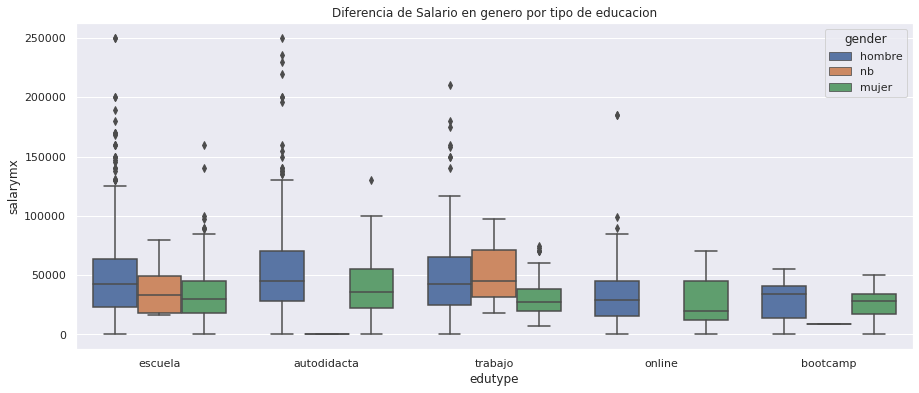

In [9]:
plt.figure(figsize=(15,6))
sns.boxplot(x='edutype',y='salarymx',hue='gender',data=df)
plt.title('Diferencia de Salario en genero por tipo de educacion')
plt.show()

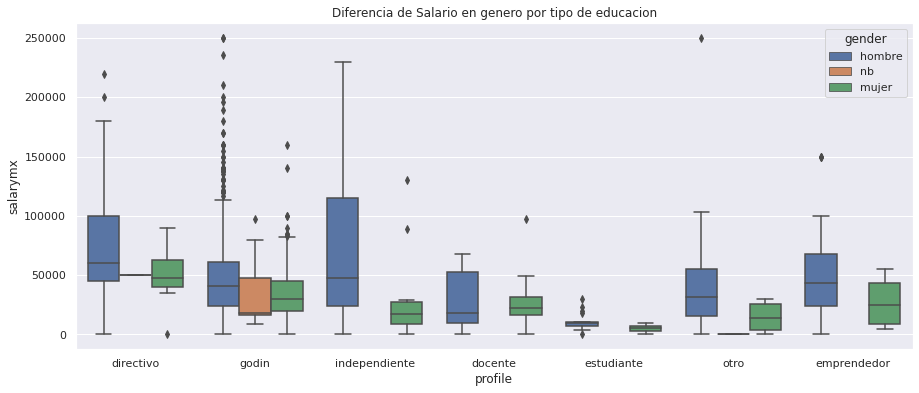

In [10]:
plt.figure(figsize=(15,6))
sns.boxplot(x='profile',y='salarymx',hue='gender',data=df)
plt.title('Diferencia de Salario en genero por tipo de educacion')
plt.show()

Parece que la clasificacion godin (Imagino tiene que ver con godinez, no esta claro) tienen el mayor numero de valores atipicos.

In [11]:
#Identificamos los limites de datos atipicos

salarymx = df1['salarymx']
iqr = salarymx.quantile(q=.75) - salarymx.quantile(q=0.25)

lower_outlier = salarymx.quantile(q=0.25) - (1.5*iqr)
upper_outlier = salarymx.quantile(q=0.75) + (1.5*iqr)

print('lower_outlier is ',lower_outlier , 'upper_outlier is',upper_outlier)


lower_outlier is  -40000.0 upper_outlier is 120000.0


In [12]:
#REmovemos los datos atipicos
df1=df1[df1['salarymx'] < 120000]
df1=df1[df1['salarymx']!=0]

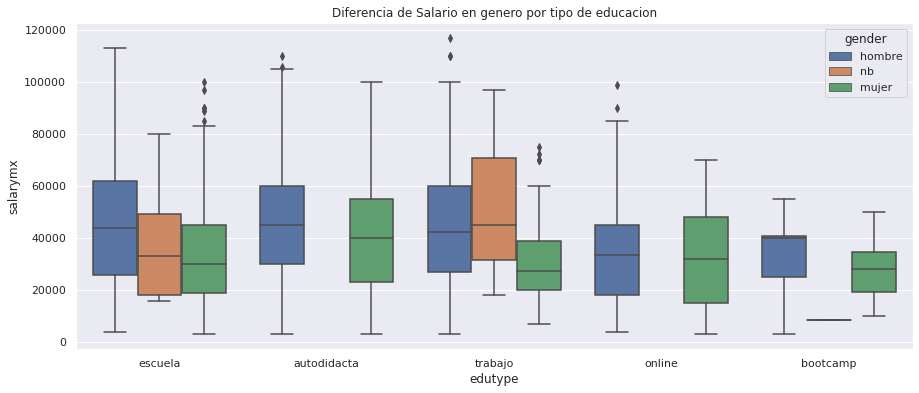

In [13]:
#Vemos la tabla nuevamente sin los resultados atipicos
plt.figure(figsize=(15,6))
sns.boxplot(x='edutype',y='salarymx',hue='gender',data=df1)
plt.title('Diferencia de Salario en genero por tipo de educacion')
plt.show()

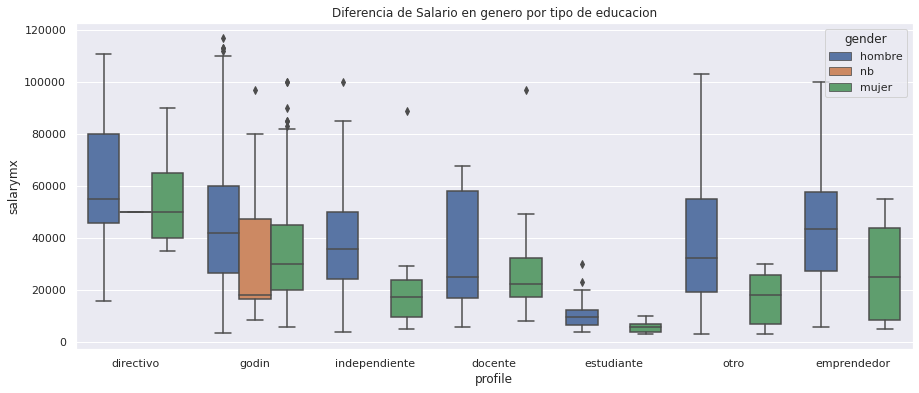

In [14]:
plt.figure(figsize=(15,6))
sns.boxplot(x='profile',y='salarymx',hue='gender',data=df1)
plt.title('Diferencia de Salario en genero por tipo de educacion')
plt.show()

Parece que en el campo de independientes y emprendedores, mayormente hombres. Y es aqui donde hay mayor diferencia entre el salario de hombres y mujeres, asi como emprendedores. Seria interesante saber si son las mujeres que se valuan menos cuando proponen sus servicios o si la industria ofrece manos si eres mujer.

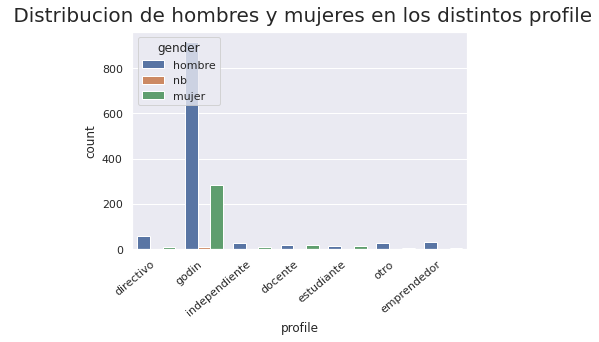

In [15]:
pl = sns.countplot(x="profile", hue= "gender", data= df1)
pl.set_xticklabels(pl.get_xticklabels(), rotation=40, ha="right");
plt.title(" Distribucion de hombres y mujeres en los distintos profile", fontsize=20, verticalalignment='bottom');

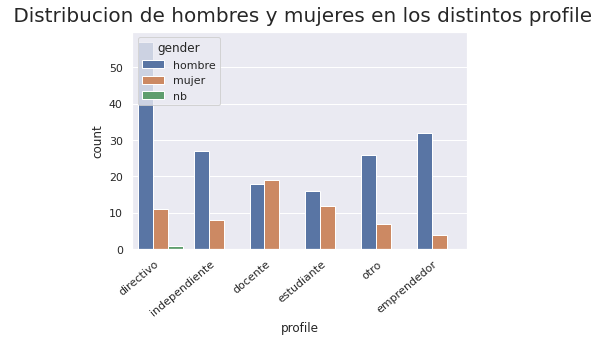

In [16]:
#separamos el profile godin para ver la distribucion de los otros perfiles
df2=df1[df1['profile']!='godin']
pl = sns.countplot(x="profile", hue= "gender", data= df2)
pl.set_xticklabels(pl.get_xticklabels(), rotation=40, ha="right");
plt.title(" Distribucion de hombres y mujeres en los distintos profile", fontsize=20, verticalalignment='bottom');

De los encuestados, habia una poblacion mayor de hombres en todas los perfiles, a excepcion de docentes. Cuando vemos la distribucion de salario, hay que ver si la difrencia es estadisticament significativa o no entre los salarios de hombres y mujeres.

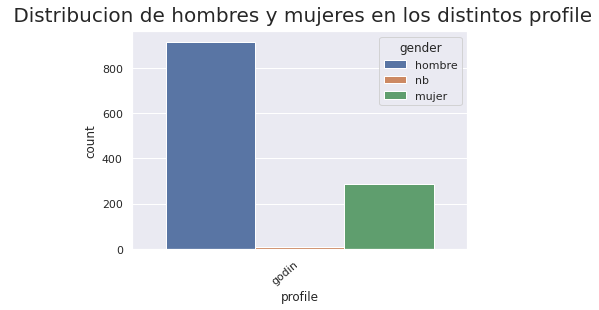

In [17]:
#separamos el profile godin para ver la distribucion de este.
df2=df1[df1['profile']=='godin']
pl = sns.countplot(x="profile", hue= "gender", data= df2)
pl.set_xticklabels(pl.get_xticklabels(), rotation=40, ha="right");
plt.title(" Distribucion de hombres y mujeres en los distintos profile", fontsize=20, verticalalignment='bottom');

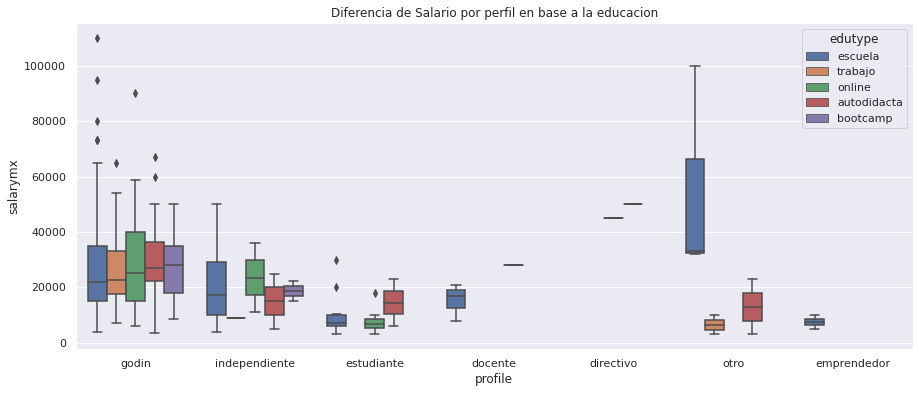

In [18]:
df_recent = df1[df1['experience']<5]
plt.figure(figsize=(15,6))
sns.boxplot(x='profile',y='salarymx',hue='edutype',data=df_recent)
plt.title('Diferencia de Salario por perfil en base a la educacion')
plt.show()

Podemos observar que las diferencias en Salario estan mas ligadas a el perfil que a el lugar donde recibieron la educacion.

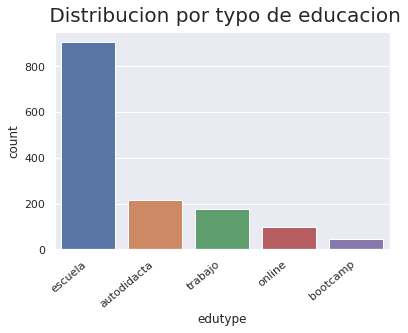

In [ ]:
#Que numero de poblacion tenemos por perfil
pl = sns.countplot(x="edutype", data= df1)
pl.set_xticklabels(pl.get_xticklabels(), rotation=40, ha="right");
plt.title(" Distribucion por typo de educacion", fontsize=20, verticalalignment='bottom');

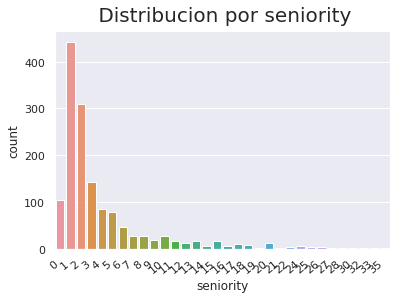

In [ ]:
#Que numero de poblacion tenemos por perfil
pl = sns.countplot(x="seniority", data= df1)
pl.set_xticklabels(pl.get_xticklabels(), rotation=40, ha="right");
plt.title(" Distribucion por seniority", fontsize=20, verticalalignment='bottom');

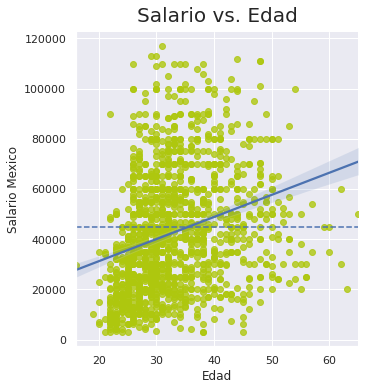

In [ ]:
sns.lmplot(x = 'age', y = 'salarymx', data = df1, scatter_kws = {'color': (174/255,199/255,14/255)})
plt.title("Salario vs. Edad", fontsize=20, verticalalignment='bottom')
plt.axhline(df['salarymx'].mean(), ls='--',color = 'b')
plt.xlabel("Edad")
plt.ylabel("Salario Mexico");

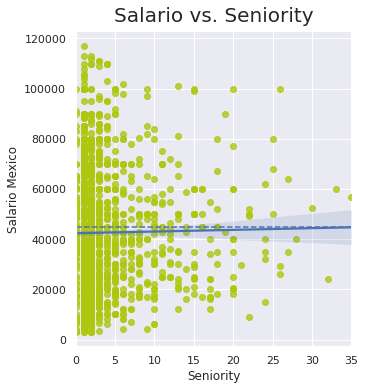

In [ ]:
sns.lmplot(x = 'seniority', y = 'salarymx', data = df1, scatter_kws = {'color': (174/255,199/255,14/255)})
plt.title("Salario vs. Seniority", fontsize=20, verticalalignment='bottom')
plt.axhline(df['salarymx'].mean(), ls='--',color = 'b')
plt.xlabel("Seniority")
plt.ylabel("Salario Mexico");

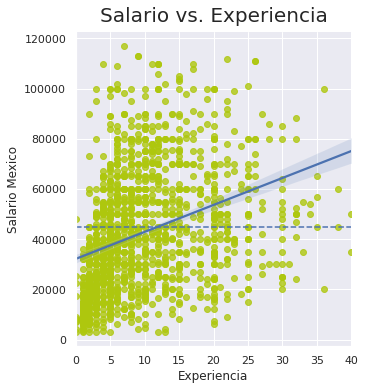

In [ ]:
sns.lmplot(x = 'experience', y = 'salarymx', data = df1, scatter_kws = {'color': (174/255,199/255,14/255)})
plt.title("Salario vs. Experiencia", fontsize=20, verticalalignment='bottom')
plt.axhline(df['salarymx'].mean(), ls='--',color = 'b')
plt.xlabel("Experiencia")
plt.ylabel("Salario Mexico");

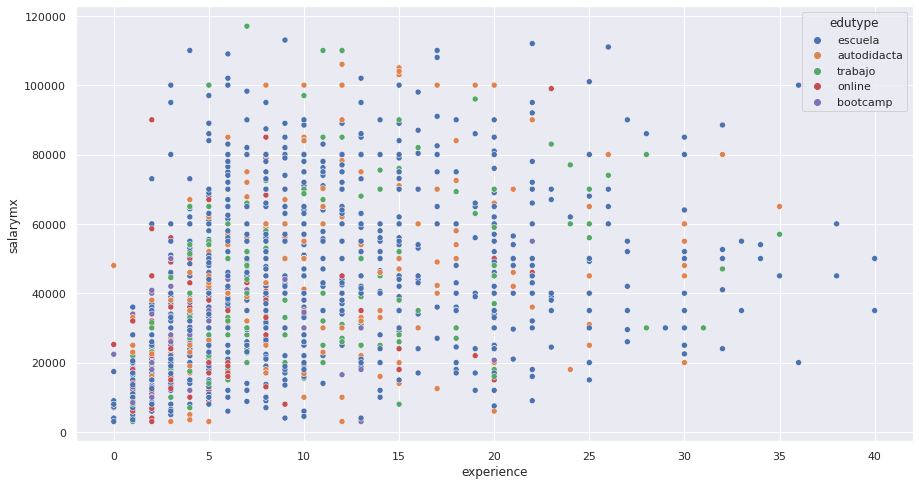

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='experience', y='salarymx', hue='edutype', #style='edutype',
                data=df1)
plt.show()

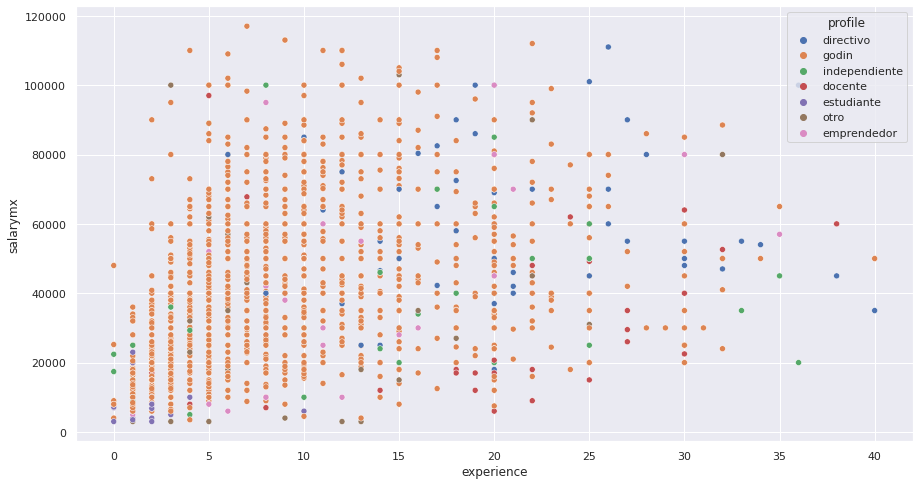

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='experience', y='salarymx', hue='profile', #style='edutype',
                data=df1)
plt.show()

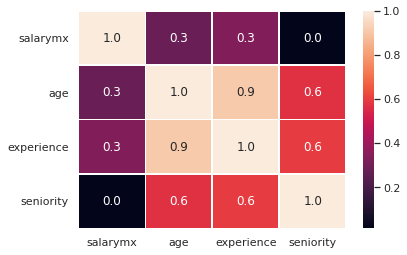

In [ ]:
plt.figure()
sns.heatmap(df1.corr(),annot=True, linewidth=0.5,fmt='.1f')
plt.show()

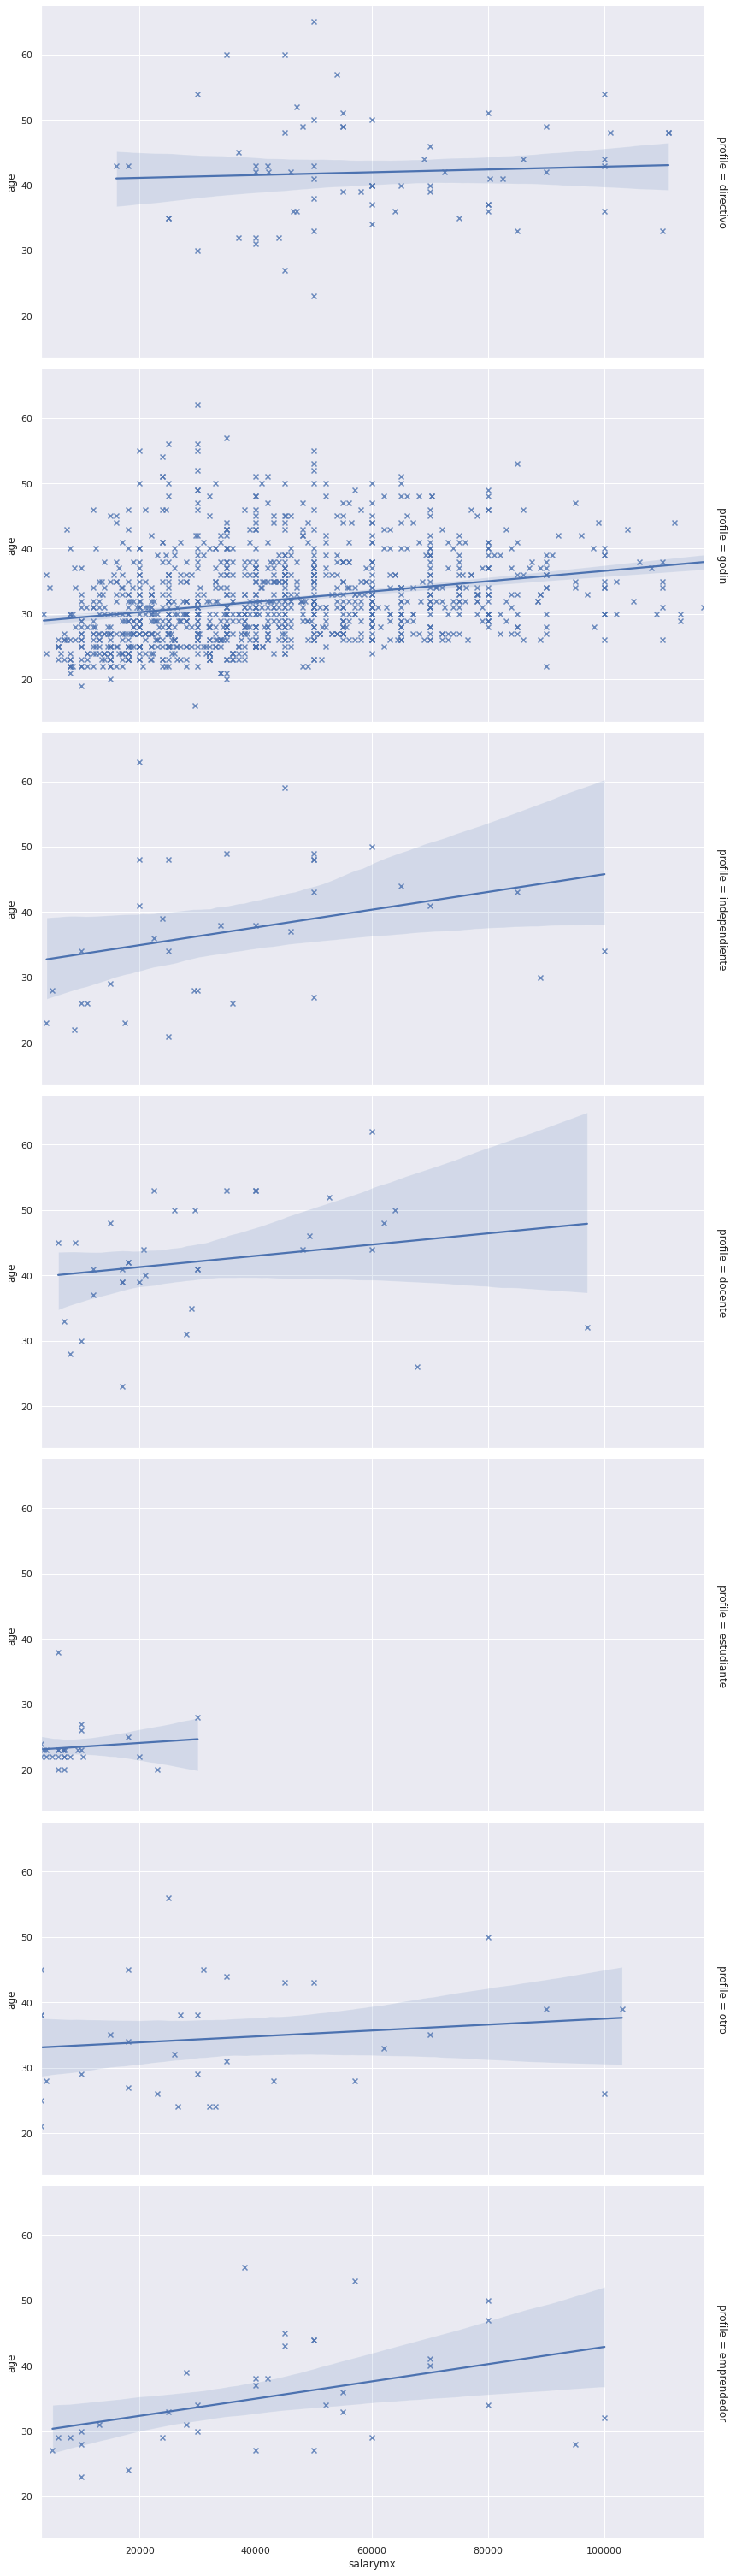

In [ ]:
#Veamos por separado cada perfil para ver si la edad continua siendo un factor en todos en relacion a la edad.
g = sns.FacetGrid(df1, row='profile', #hue="Disadvantaged", 
                  margin_titles=True, height=6, aspect=2, palette="plasma")

g.map(sns.regplot,'salarymx', 'age',marker="x")

#_=g.set(xlim=(8800, 17500), 
# ylim=(2300, 2700))
_=g.add_legend()


Directivo - La edad no parece tener mucho impacto ya que hay salarios bajos y altos a distintas edades, pero empezamos a ver a partir de los 50 los salarios bajan drasticamente en todas las categorias.
Para Independientes y emprendedores parece haber una relacion en cuanto a la edad muy positiva, despues de los 50 baja, aunque la muestra es pequeña y parece bajar en menor grado que en otros perfiles.
En cuanto al genero, en todos los perfiles a excepcion de godin y emprendedor, las mujeres parece tener una baja relacion con salarios no cambiando con a edad. Seria interesante saber a que se debe

In [ ]:
#Veamos si los tipos de estudio y perfiles estan relacionados o son independientes
cross=pd.crosstab(df1['profile'], df1['edutype'])
cross

edutype,autodidacta,bootcamp,escuela,online,trabajo
profile,,,,,
directivo,22,0,48,6,11
docente,5,1,33,0,1
emprendedor,15,0,18,1,8
estudiante,2,1,18,8,1
godin,179,46,846,84,160
independiente,18,2,22,4,6
otro,11,2,15,5,6


In [ ]:
dis_perfil_prop = round(cross.div(cross.sum(axis=1), axis=0)*100,2)
dis_perfil_prop

edutype,autodidacta,bootcamp,escuela,online,trabajo
profile,,,,,
directivo,25.29,0.00,55.17,6.90,12.64
docente,12.50,2.50,82.50,0.00,2.50
emprendedor,35.71,0.00,42.86,2.38,19.05
estudiante,6.67,3.33,60.00,26.67,3.33
godin,13.61,3.50,64.33,6.39,12.17
independiente,34.62,3.85,42.31,7.69,11.54
otro,28.21,5.13,38.46,12.82,15.38


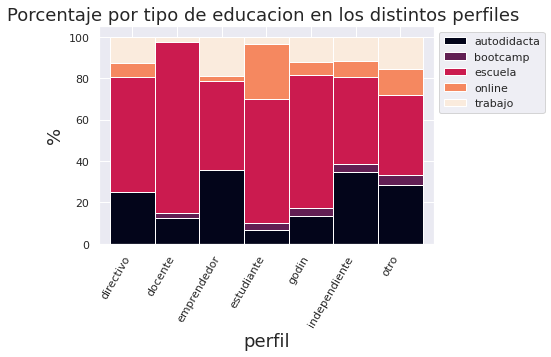

In [ ]:
plt_prop = dis_perfil_prop.plot(kind='bar', stacked = True, width = 1,colormap='rocket')
plt_prop.legend(bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.xticks(rotation=60, ha='right')
_ = plt.title('Porcentaje por tipo de educacion en los distintos perfiles ', fontsize=18)
_ = plt.xlabel('perfil', fontsize=18)
_ = plt.ylabel("%", fontsize=18)


In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
g, p, dof, expctd = chi2_contingency(cross)
print("Valor P de  Chi cuadrada para Tipo de Educacion vs. Perfil =", p)

Valor P de  Chi cuadrada para Tipo de Educacion vs. Perfil = 4.870024345040851e-09


vemos que el tipo de educacion y el perfil no son variables independientes, ya que por ejemplo los docentes son mayormente educados en la escuela y los emprendedores o independientes parece tener mas educacion autodidacta.

In [ ]:
#Nivel de ingles es independiente de perfil
crosse=pd.crosstab(df1['profile'], df1['english_label'])
cross

english_label,Avanzado: Puedo conversar y escribir sin problemas sobre cualquier tema (ILR 4),Elemental: Sé lo básico para sobrevivir (ILR 1),Limitado: Me doy a entender pero con errores de gramática (ILR 2),Nativo o bilingue (ILR 5),Ninguno (ILR 0),Profesional: Puedo interactuar profesionalmente con colegas y clientes (ILR 3)
profile,,,,,,
directivo,27,6,17,10,0,27
docente,6,2,12,0,0,20
emprendedor,11,4,16,0,0,11
estudiante,4,5,12,5,0,4
godin,326,135,376,53,8,417
independiente,19,1,21,1,0,10
otro,7,3,14,2,1,12


In [ ]:
dis_english_prop = round(crosse.div(crosse.sum(axis=1), axis=0)*100,2)
dis_english_prop

english_label,Avanzado: Puedo conversar y escribir sin problemas sobre cualquier tema (ILR 4),Elemental: Sé lo básico para sobrevivir (ILR 1),Limitado: Me doy a entender pero con errores de gramática (ILR 2),Nativo o bilingue (ILR 5),Ninguno (ILR 0),Profesional: Puedo interactuar profesionalmente con colegas y clientes (ILR 3)
profile,,,,,,
directivo,31.03,6.90,19.54,11.49,0.00,31.03
docente,15.00,5.00,30.00,0.00,0.00,50.00
emprendedor,26.19,9.52,38.10,0.00,0.00,26.19
estudiante,13.33,16.67,40.00,16.67,0.00,13.33
godin,24.79,10.27,28.59,4.03,0.61,31.71
independiente,36.54,1.92,40.38,1.92,0.00,19.23
otro,17.95,7.69,35.90,5.13,2.56,30.77


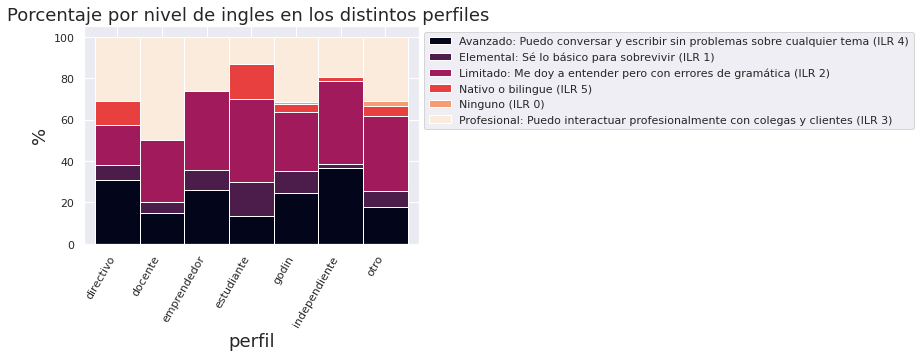

In [ ]:
plt_prop = dis_english_prop.plot(kind='bar', stacked = True, width = 1,colormap='rocket')
plt_prop.legend(bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.xticks(rotation=60, ha='right')
_ = plt.title('Porcentaje por nivel de ingles en los distintos perfiles ', fontsize=18)
_ = plt.xlabel('perfil', fontsize=18)
_ = plt.ylabel("%", fontsize=18)


In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
g, p, dof, expctd = chi2_contingency(crosse)
print("Valor P de  Chi cuadrada para Ingles  vs. Perfil =", p)

Valor P de  Chi cuadrada para Ingles  vs. Perfil = 0.0004243239479789972


Al parecer las variables muestran dependencia entre el perfil y el nivel de ingles. Mayormente avanzados son los directivos, emprendedores e independientes

In [ ]:
#Nivel de ingles es independiente de perfil
crossg=pd.crosstab(df1['profile'], df1['gender'])
crossg

gender,hombre,mujer,nb
profile,,,
directivo,74,12,1
docente,21,19,0
emprendedor,38,4,0
estudiante,16,14,0
godin,1010,296,9
independiente,42,10,0
otro,30,8,1


In [ ]:
dis_gender_prop = round(crossg.div(crossg.sum(axis=1), axis=0)*100,2)
dis_gender_prop

gender,hombre,mujer,nb
profile,,,
directivo,85.06,13.79,1.15
docente,52.50,47.50,0.00
emprendedor,90.48,9.52,0.00
estudiante,53.33,46.67,0.00
godin,76.81,22.51,0.68
independiente,80.77,19.23,0.00
otro,76.92,20.51,2.56


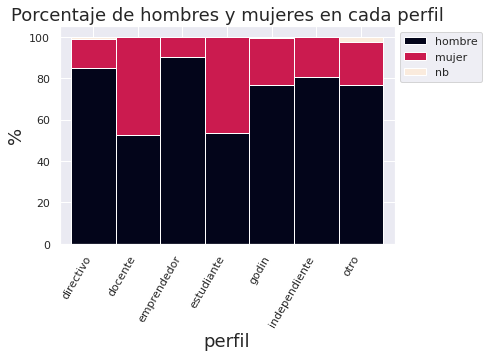

In [ ]:
plt_prop = dis_gender_prop.plot(kind='bar', stacked = True, width = 1,colormap='rocket')
plt_prop.legend(bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.xticks(rotation=60, ha='right')
_ = plt.title('Porcentaje de hombres y mujeres en cada perfil', fontsize=18)
_ = plt.xlabel('perfil', fontsize=18)
_ = plt.ylabel("%", fontsize=18)

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
g, p, dof, expctd = chi2_contingency(crosse)
print("Valor P de  Chi cuadrada para Genero  vs. Perfil =", p)

Valor P de  Chi cuadrada para Genero  vs. Perfil = 0.0004243239479789972


Vemos que los perfiles y el genero no son independientes. Es en el area de educacion donde hay mas mujeres, en la encuesta realizada

In [20]:
crossgi=pd.crosstab(df1['english_label'], df1['gender'])
crossgi

gender,hombre,mujer,nb
english_label,,,
Avanzado: Puedo conversar y escribir sin problemas sobre cualquier tema (ILR 4),258,79,3
Elemental: Sé lo básico para sobrevivir (ILR 1),109,35,1
Limitado: Me doy a entender pero con errores de gramática (ILR 2),312,124,0
Nativo o bilingue (ILR 5),35,15,2
Ninguno (ILR 0),4,1,2
Profesional: Puedo interactuar profesionalmente con colegas y clientes (ILR 3),373,92,3


In [21]:
dis_gendere_prop = round(crossgi.div(crossgi.sum(axis=0), axis=1)*100,2).T
dis_gendere_prop

english_label,Avanzado: Puedo conversar y escribir sin problemas sobre cualquier tema (ILR 4),Elemental: Sé lo básico para sobrevivir (ILR 1),Limitado: Me doy a entender pero con errores de gramática (ILR 2),Nativo o bilingue (ILR 5),Ninguno (ILR 0),Profesional: Puedo interactuar profesionalmente con colegas y clientes (ILR 3)
gender,,,,,,
hombre,23.65,9.99,28.60,3.21,0.37,34.19
mujer,22.83,10.12,35.84,4.34,0.29,26.59
nb,27.27,9.09,0.00,18.18,18.18,27.27


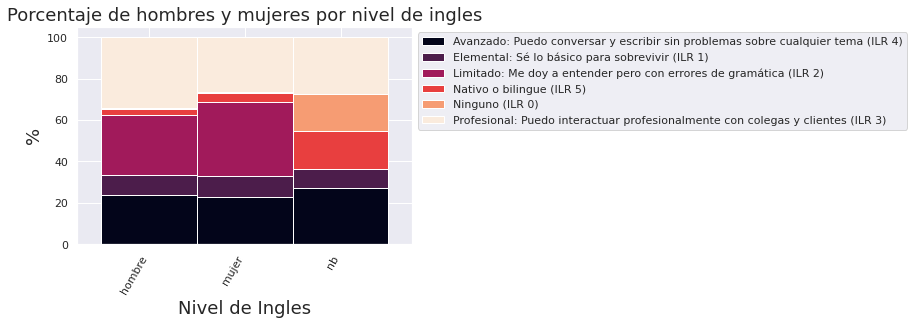

In [22]:
plt_prop = dis_gendere_prop.plot(kind='bar', stacked = True, width = 1,colormap='rocket')
plt_prop.legend(bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.xticks(rotation=60, ha='right')
_ = plt.title('Porcentaje de hombres y mujeres por nivel de ingles', fontsize=18)
_ = plt.xlabel('Nivel de Ingles', fontsize=18)
_ = plt.ylabel("%", fontsize=18)

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
g, p, dof, expctd = chi2_contingency(crossgi)
print("Valor P de  Chi cuadrada para Genero  vs. Nivel de ingles =", p)

Valor P de  Chi cuadrada para Genero  vs. Nivel de ingles = 2.1849893428959644e-28


In [ ]:
Vemos que los niveles de ingles entre hombre y mujer 

In [ ]:
_ = sns.jointplot(x='salarymx', y='Mean Scale Score', hue='Disadvantaged', palette='plasma',data=school_df)
_.fig.set_size_inches(8,6)